In [ ]:
pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 665.5 MB 96.2 MB/s
     |████████████████████████████████| 1.3 MB 33.1 MB/s 
     |████████████████████████████████| 463 kB 56.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
    Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636


In [ ]:
pip install tensorflow-quantum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 21.0 MB/s 
     |████████████████████████████████| 90 kB 11.0 MB/s 
     |████████████████████████████████| 6.1 MB 42.1 MB/s 
     |████████████████████████████████| 90 kB 11.3 MB/s 
     |████████████████████████████████| 541 kB 47.0 MB/s 
     |████████████████████████████████| 100 kB 11.4 MB/s 
     |████████████████████████████████| 1.8 MB 62.3 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 93 kB 2.1 MB/s 
     |████████████████████████████████| 93 kB 1.9 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.9 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 92 kB 1.

In [ ]:
import numpy as np 
import sympy as sp
import pandas as pd
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.contrib.svg import SVGCircuit

%matplotlib inline
import matplotlib.pyplot as plt



In [ ]:
from google.colab import files
upload_file = files.upload()

Saving QIS_EXAM_200Events.npz to QIS_EXAM_200Events.npz


In [ ]:
data = np.load('./QIS_EXAM_200Events.npz',allow_pickle = True)

In [ ]:
# print(data)
# data = pd.DataFrame(data)

In [ ]:
X_train = data['training_input'].item()
X_test = data['test_input'].item()
# print(X_train['0'])
X_train_0 = X_train['0']
X_test_0 = X_test['0']
X_train_1 = X_train['1']
X_test_1 = X_test['1']

X_train = np.concatenate((X_train_0,X_train_1),axis=0)
X_test = np.concatenate((X_test_0,X_test_1),axis=0)

y_train = np.zeros((len(X_train),1))
y_test = np.zeros((len(X_test),1))
y_train[len(X_train_0):] = 1
y_test[len(X_test_0):] = 1
#print(X_train)

In [ ]:
# Don't run this codeblock over and over again. If needed load the dataset again and then execute this once again.

y_train = tf.keras.utils.to_categorical(y_train)*2-1  
y_test = tf.keras.utils.to_categorical(y_test)*2-1
# print(y_train.shape)
y_train = np.concatenate((y_train,np.ones((len(y_train),1))),axis=1 )
y_test = np.concatenate((y_test,np.ones((len(y_test),1))),axis=1)
# print(y_train)
# print(y_test)

In [ ]:
def generate_quantum_data(X,qubits):
    quantum_data =[]
    for i in X:
        circuit = cirq.Circuit()
        
        for j in range(len(i)):
            circuit.append(cirq.ry(i[j])(qubits[j]))
            
        quantum_data.append(circuit)
    return quantum_data

In [ ]:
qubits = cirq.GridQubit.rect(5, 1)
train_quantum_data = tfq.convert_to_tensor(generate_quantum_data(X_train, qubits))
test_quantum_data = tfq.convert_to_tensor(generate_quantum_data(X_test, qubits))

In [ ]:
def one_qubit_unitary(qubits,num_qubits,symbols) -> cirq.Circuit :
  circuit = cirq.Circuit()
  k=0
  for i in range(num_qubits):
    circuit.append(cirq.rx(symbols[k])(qubits[i]))
    k+=1
  for i in range(num_qubits):
    circuit.append(cirq.rz(symbols[k])(qubits[i]))
    k+=1
  
  return circuit

In [ ]:
def two_qubit_unitary(qubits,num_qubits,symbols):
  circuit = cirq.Circuit()
  k=0
  for i in range(1,num_qubits,2):
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    circuit.append(cirq.rz(symbols[k])(qubits[i]))
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    k+=1
  
  for i in range(2,num_qubits,2):
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    circuit.append(cirq.rz(symbols[k])(qubits[i]))
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    k+=1
  return circuit  

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


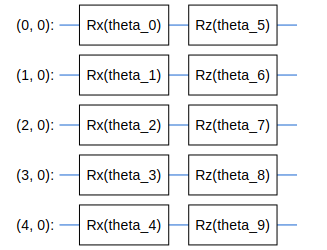

In [ ]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit.rect(5,1),5,sp.symbols('theta_:10')))
# SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(5,1),5,sp.symbols('theta_:4')))

In [ ]:
def generator(qubits,symbols,layers=1):
  circuit = cirq.Circuit()
  num_qubits = len(qubits)
  num_data_qubits = int(num_qubits/2)
  symbols_one = symbols[:2*layers*num_qubits]
  symbols_two = symbols[2*layers*num_qubits:]
  random_rotations = np.random.normal(loc=0.0,scale=np.pi/4,size=num_data_qubits)
  for i in range(num_data_qubits):
    circuit.append(cirq.ry(random_rotations[i])(qubits[i]))
  # k=0
  for l in range(layers):
    circuit += one_qubit_unitary(qubits,num_qubits,symbols_one[l*2*num_qubits:(l+1)*2*num_qubits])
    circuit += two_qubit_unitary(qubits,num_qubits,symbols_two[l*(num_qubits-1):(l+1)*(num_qubits-1)])
  
  return circuit

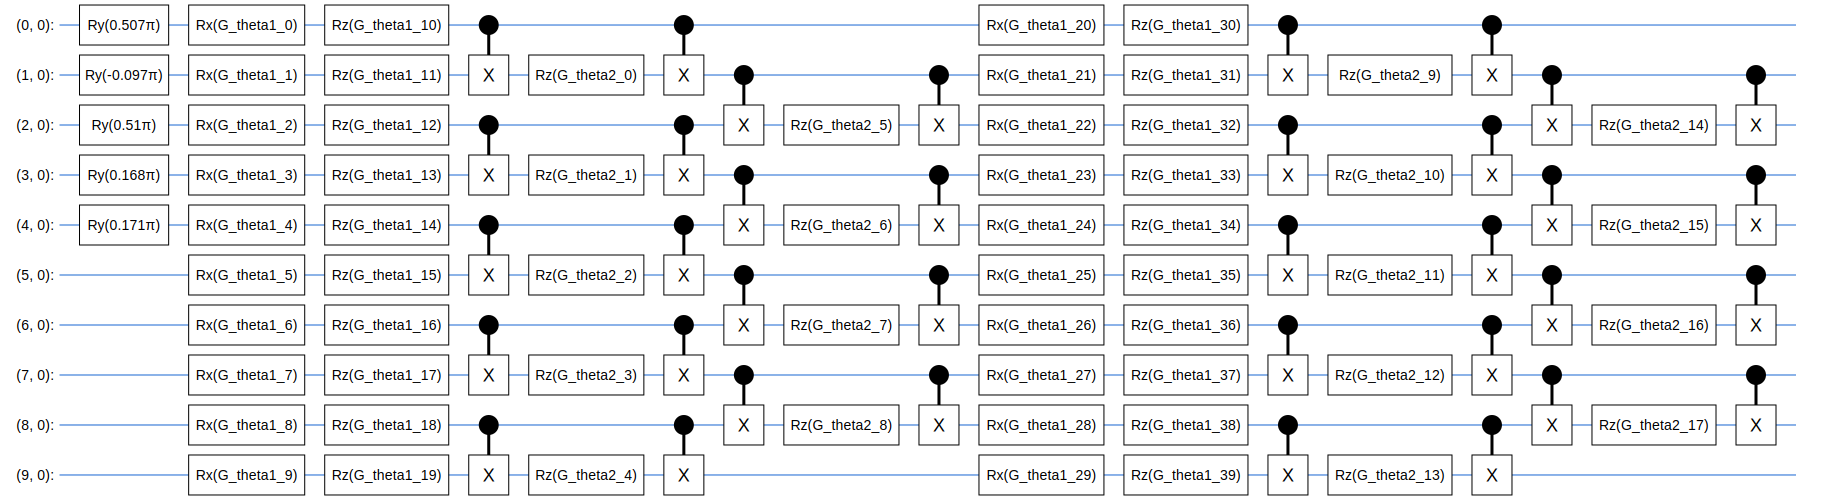

In [ ]:
SVGCircuit(generator(cirq.GridQubit.rect(10,1),sp.symbols('G_theta1_:40')+sp.symbols('G_theta2_:18'),layers=2))

In [ ]:
def discriminator(data_qubits,output_qubits,symbols,layers=1):
  circuit = cirq.Circuit()
  qubits=data_qubits+output_qubits
  num_qubits = len(qubits)
  num_data_qubits = len(data_qubits)
  symbols_one = symbols[:2*layers*num_qubits]
  symbols_two = symbols[2*layers*num_qubits:]
  for i in range(num_data_qubits):
    circuit.append(cirq.H(qubits[i]))
  # k=0
  for l in range(layers):
    circuit += one_qubit_unitary(qubits,num_qubits,symbols_one[l*2*num_qubits:(l+1)*2*num_qubits])
    circuit += two_qubit_unitary(qubits,num_qubits,symbols_two[l*(num_qubits-1):(l+1)*(num_qubits-1)])
  
  return circuit


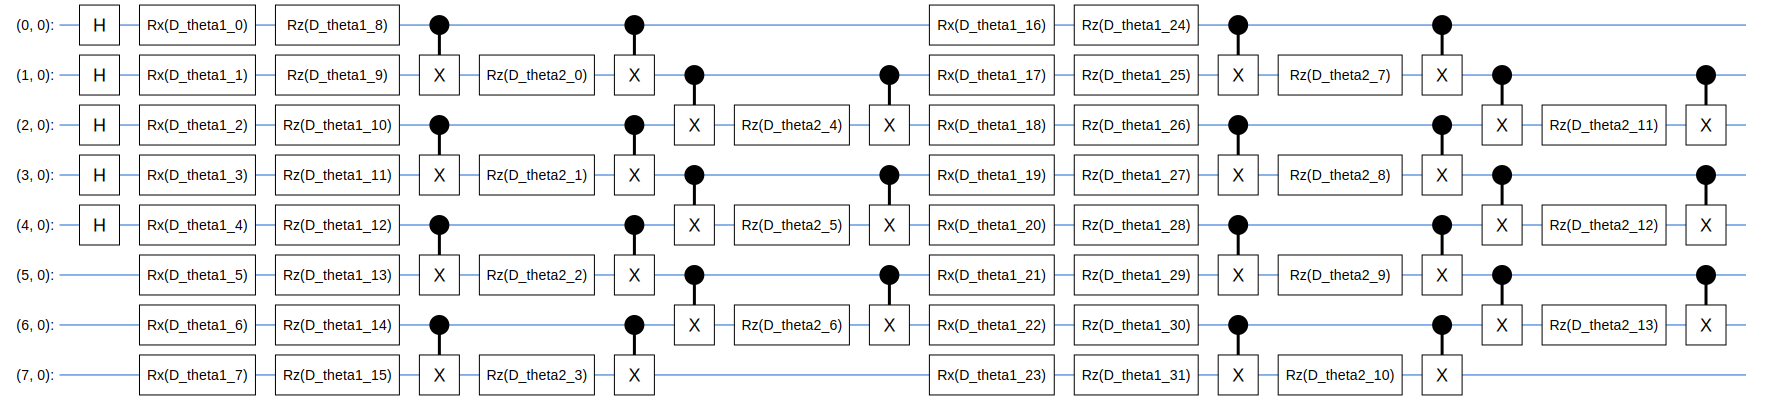

In [ ]:
disc_qubits = cirq.GridQubit.rect(5+3,1)
SVGCircuit(discriminator(disc_qubits[0:5],disc_qubits[5:],sp.symbols('D_theta1_:32')+sp.symbols('D_theta2_:14'),layers=2))

In [ ]:
def generator_discriminator(qubits,symbols_gen,symbols_disc,gen_layers=1,disc_layers=1):
  circuit = cirq.Circuit()
  gen_qubits = qubits[:10]
  disc_qubits = qubits[:5]+qubits[10:]
  circuit += generator(gen_qubits,symbols_gen,gen_layers)                                                #symbols_gen[:gen_layers*2*len(gen_qubits)]+symbols_gen[gen_layers*2*len(gen_qubits):]
  circuit += discriminator(disc_qubits[:5],disc_qubits[5:],symbols_disc,disc_layers)          #symbols_disc[:disc_layers*2*len(disc_qubits)]+symbols_disc[disc_layers*2*len(disc_qubits):]
  # return len(gen_qubits),len(disc_qubits)
  return circuit

58


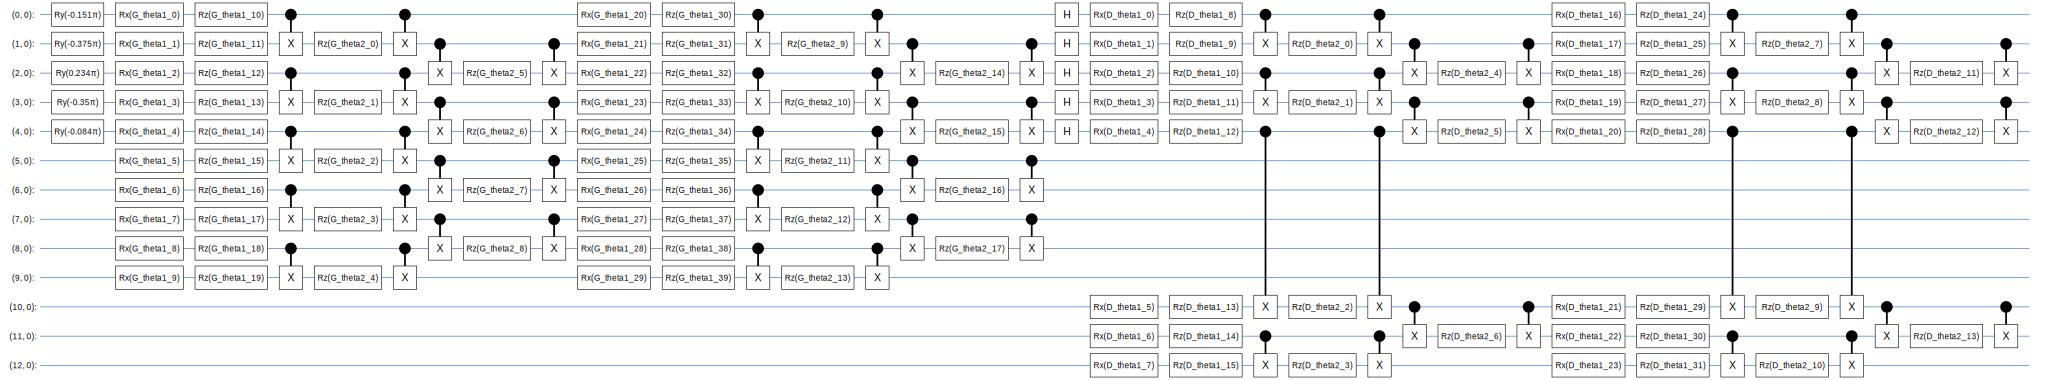

In [ ]:
generator_symbols = sp.symbols('G_theta1_:40') + sp.symbols('G_theta2_:18')
print(len(generator_symbols))
discriminator_symbols = sp.symbols('D_theta1_:32') + sp.symbols('D_theta2_:16')
# generator_discriminator(cirq.GridQubit.rect(13,1),generator_symbols,discriminator_symbols,layers=1)
SVGCircuit(generator_discriminator(cirq.GridQubit.rect(13,1),generator_symbols,discriminator_symbols,gen_layers=2,disc_layers=2))

# **Model**


**Hyperparameters**

In [ ]:
gen_layers = 5
disc_layers = 5

num_classes = 2

**Model Parameters**

In [ ]:
features = 5

# 
# 
train_gen_symbols = sp.symbols('G_theta1_:'+str(2*gen_layers*2*features)) + sp.symbols('G_theta2_:'+str(gen_layers*(2*features-1)))
print(len(train_gen_symbols))
train_disc_symbols = sp.symbols('D_theta1_:'+str(2*disc_layers*2*(features+num_classes+1))) + sp.symbols('D_theta2_:'+ str(disc_layers*(features+num_classes)))
print(train_gen_symbols)
model_qubits = cirq.GridQubit.rect(features*2+num_classes+1,1)

145
(G_theta1_0, G_theta1_1, G_theta1_2, G_theta1_3, G_theta1_4, G_theta1_5, G_theta1_6, G_theta1_7, G_theta1_8, G_theta1_9, G_theta1_10, G_theta1_11, G_theta1_12, G_theta1_13, G_theta1_14, G_theta1_15, G_theta1_16, G_theta1_17, G_theta1_18, G_theta1_19, G_theta1_20, G_theta1_21, G_theta1_22, G_theta1_23, G_theta1_24, G_theta1_25, G_theta1_26, G_theta1_27, G_theta1_28, G_theta1_29, G_theta1_30, G_theta1_31, G_theta1_32, G_theta1_33, G_theta1_34, G_theta1_35, G_theta1_36, G_theta1_37, G_theta1_38, G_theta1_39, G_theta1_40, G_theta1_41, G_theta1_42, G_theta1_43, G_theta1_44, G_theta1_45, G_theta1_46, G_theta1_47, G_theta1_48, G_theta1_49, G_theta1_50, G_theta1_51, G_theta1_52, G_theta1_53, G_theta1_54, G_theta1_55, G_theta1_56, G_theta1_57, G_theta1_58, G_theta1_59, G_theta1_60, G_theta1_61, G_theta1_62, G_theta1_63, G_theta1_64, G_theta1_65, G_theta1_66, G_theta1_67, G_theta1_68, G_theta1_69, G_theta1_70, G_theta1_71, G_theta1_72, G_theta1_73, G_theta1_74, G_theta1_75, G_theta1_76, G_th

**Loss functions** 

In [ ]:
C = 1/2
@tf.function
def discriminator_loss(y_true,y_pred):
  D_true = (y_true[:,2]+1)/2
  D_pred = (y_pred[:,2]+1)/2

  #Loss in predicting true or fake
  L_tf = -(tf.math.log(D_pred + 1e-15)*D_true + tf.math.log((1-D_pred) + 1e-15)*(1-D_true))
  L_tf = tf.reduce_mean(L_tf,axis=0)
  
  #Loss in classification
  C_true = (y_true[:,:2]+1)/2
  C_pred = (y_pred[:,:2]+1)/2
  
  D_true_size = tf.cast(tf.size(tf.where(D_true==1),out_type = tf.int32),dtype = tf.float32) + 1e-15
  L_c = tf.math.reduce_sum(tf.keras.losses.CategoricalCrossentropy(reduction='none')(C_true,C_pred)*D_true)/D_true_size

  #Total Loss of discriminator
  total_loss = C*L_c + (1-C)*L_tf
  return total_loss

In [ ]:
@tf.function
def discriminator_accuracy(y_true,y_pred):
  D_true = (y_true[:,2]+1)/2

  C_real_true = (y_true[:,:2]+1)/2
  C_real_pred = (y_pred[:,:2]+1)/2
  C_real_true = tf.math.argmax(C_real_true,axis=1)
  C_real_pred = tf.math.argmax(C_real_pred,axis=1)

  D_true_size = tf.cast(tf.size(tf.where(D_true==1),out_type=tf.int32),dtype= tf.float32) +1e-15
  same = tf.cast(C_real_true == C_real_pred,dtype = tf.float32)*D_true

  return tf.math.reduce_sum(same)/D_true_size

In [ ]:
@tf.function
def generator_loss(y_true,y_pred):
  y_pred = (y_pred+1)/2
  return tf.reduce_mean((-1)*tf.math.log(y_pred),axis=0)

In [ ]:
def discriminator_model(disc_weights):
  disc_readout_ops = [cirq.Z(model_qubits[-1*(num_classes+1)+i]) for i in range(num_classes+1)]

  input_data = tf.keras.Input(shape=(),dtype=tf.dtypes.string)
  qdisc_layer = tfq.layers.PQC(discriminator(model_qubits[:int((len(model_qubits)-(num_classes+1))/2)],
                                  model_qubits[(len(model_qubits)-(num_classes+1)):],disc_weights,layers=disc_layers),       # disc_weights[disc_layers*2*(features+num_classes+1):],disc_weights[disc_layers*2*(features+num_classes+1):]
                           disc_readout_ops,
                           name='qdisc_layer')(input_data)
                          
  qdisc_model= tf.keras.Model(inputs=[input_data],outputs=[qdisc_layer])
  qdisc_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss = [discriminator_loss],
                      metrics = [discriminator_accuracy])
  return qdisc_model

# qdisc_model = discriminator_model(train_disc_symbols)
# tf.keras.utils.plot_model(qdisc_model,
#                           show_shapes=True,
#                           show_layer_names=True,
#                           dpi=70)

In [ ]:
def generator_model(disc_weights,gen_weights):
  gen_readout_ops = cirq.Z(model_qubits[-1])
  # gen_readout_ops = [cirq.Z(model_qubits[-1*(num_classes+1)+i]) for i in range(num_classes+1)]
  input_data = tf.keras.Input(shape=(),dtype=tf.dtypes.string)
  
  qgen_layer = tfq.layers.PQC(generator_discriminator(model_qubits,gen_weights,disc_weights,gen_layers=gen_layers,disc_layers=disc_layers),
                           gen_readout_ops,
                           name='qgen_layer')(input_data)

  qgen_model= tf.keras.Model(inputs=[input_data],outputs=[qgen_layer])
  qgen_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
               loss=[generator_loss])
  
  return qgen_model

  # qgen_model = generator_model(qdisc_model.get_weights()[0],train_gen_symbols)
  # tf.keras.utils.plot_model(qgen_model,
  #                           show_shapes=True,
  #                           show_layer_names=True,
  #                           dpi=70)

In [ ]:
# Generatting identity data for generator training in first cycle
def generate_identity_data(X):
  quantum_data=[]
  for i in X:
    circuit = cirq.Circuit()
    quantum_data.append(circuit)
  return quantum_data

In [ ]:
identity_data = tfq.convert_to_tensor(generate_identity_data(X_train))
identity_label = np.zeros((len(identity_data)),)

print(len(identity_data))
print(identity_label.shape)
print(type(generate_identity_data(X_train)[10]))

100
(100,)
<class 'cirq.circuits.circuit.Circuit'>


In [ ]:
def generate_fake_data(X,qubits,symbols,layers=1):
  quantum_data=[]
  
  for i in X:
    quantum_data.append(generator(qubits[:2*len(i)],symbols,layers))         #symbols[:2*gen_layers*2*len(i)]+symbols[2*layers*2*len(i):]
  
  return quantum_data
print(len(X_train[0]))

5


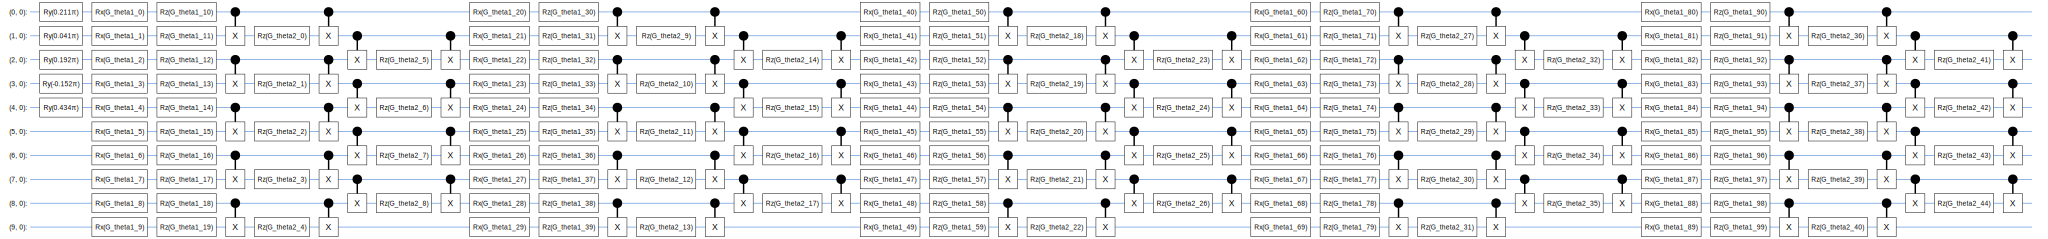

In [ ]:
fake_quantum_data = generate_fake_data(X_train,model_qubits,train_gen_symbols,gen_layers)
y_true_fake = np.zeros((len(fake_quantum_data), num_classes+1))
y_true_fake[:, 2] += (-1)
SVGCircuit(fake_quantum_data[0])

In [ ]:
qdisc_model = discriminator_model(train_disc_symbols)
# print(qdisc_model.get_weights()[0])
# print(len(qdisc_model.get_weights()[0]))
qgen_model = generator_model(qdisc_model.get_weights()[0],train_gen_symbols) 

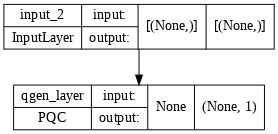

In [ ]:
tf.keras.utils.plot_model(qgen_model,
                            show_shapes=True,
                            show_layer_names=True,
                            dpi=70)

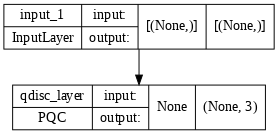

In [ ]:
tf.keras.utils.plot_model(qdisc_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

In [ ]:
qgen_model.summary()
print("---------------------------------------------------")
qdisc_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 qgen_layer (PQC)            (None, 1)                 145       
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
---------------------------------------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 qdisc_layer (PQC)           (None, 3)                 115       
                                                            

In [ ]:
def train_qgen(epochs,batch,verbose):
  return qgen_model.fit(x=identity_data,
                  y=identity_label,
                  batch_size=batch,
                  epochs=epochs,
                  verbose=verbose
                  )


In [ ]:
def train_qdisc(epochs,batch,verbose):
  return qdisc_model.fit(x=train_gen_data,
                   y=y_gen_train,
                   batch_size=batch,
                   epochs=epochs,
                   verbose=verbose,
                   validation_data=(test_gen_data, y_gen_test)
                   )

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]

qgen_model = generator_model(qdisc_model.get_weights()[0],train_gen_symbols)


In [ ]:
H = train_qgen(100,50,1)

Epoch 1/100
2/2 [==============================] - 5s 2s/step - loss: 0.4781
Epoch 2/100
2/2 [==============================] - 4s 2s/step - loss: 0.4777
Epoch 3/100
2/2 [==============================] - 4s 2s/step - loss: 0.4774
Epoch 4/100
2/2 [==============================] - 4s 2s/step - loss: 0.4770
Epoch 5/100
2/2 [==============================] - 5s 2s/step - loss: 0.4766
Epoch 6/100
2/2 [==============================] - 4s 2s/step - loss: 0.4763
Epoch 7/100
2/2 [==============================] - 4s 2s/step - loss: 0.4760
Epoch 8/100
2/2 [==============================] - 4s 2s/step - loss: 0.4757
Epoch 9/100
2/2 [==============================] - 5s 2s/step - loss: 0.4754
Epoch 10/100
2/2 [==============================] - 4s 2s/step - loss: 0.4751
Epoch 11/100
2/2 [==============================] - 6s 3s/step - loss: 0.4749
Epoch 12/100
2/2 [==============================] - 4s 2s/step - loss: 0.4747
Epoch 13/100
2/2 [==============================] - 4s 2s/step - loss: 0.

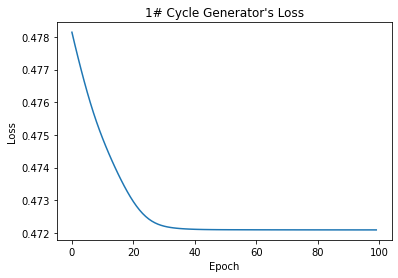

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("1# Cycle Generator's Loss")
plt.show()

In [ ]:
# Generating data for discriminator by mixing real and fake data
# C = 1/2 (default value)
train_gen_data = tfq.convert_to_tensor(generate_quantum_data(X_train,model_qubits) + generate_fake_data(X_train,model_qubits,qgen_model.get_weights()[0]),gen_layers)
test_gen_data = tfq.convert_to_tensor(generate_quantum_data(X_test,model_qubits) + generate_fake_data(X_test,model_qubits,qgen_model.get_weights()[0]),gen_layers)

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)
                            
print(len(train_gen_data), len(test_gen_data))
print(y_gen_train.shape, y_gen_test.shape)  

200 200
(200, 3) (200, 3)


In [ ]:
# Fit the Discriminator Model
H = train_qdisc(80, 50, 1)

Epoch 1/80
4/4 [==============================] - 6s 1s/step - loss: 0.8176 - discriminator_accuracy: 0.5598 - val_loss: 0.6081 - val_discriminator_accuracy: 0.2500
Epoch 2/80
4/4 [==============================] - 4s 1s/step - loss: 0.8231 - discriminator_accuracy: 0.5634 - val_loss: 0.6002 - val_discriminator_accuracy: 0.2500
Epoch 3/80
4/4 [==============================] - 5s 1s/step - loss: 0.7997 - discriminator_accuracy: 0.5447 - val_loss: 0.5926 - val_discriminator_accuracy: 0.2500
Epoch 4/80
4/4 [==============================] - 4s 1s/step - loss: 0.7929 - discriminator_accuracy: 0.5398 - val_loss: 0.5857 - val_discriminator_accuracy: 0.2500
Epoch 5/80
4/4 [==============================] - 4s 1s/step - loss: 0.7883 - discriminator_accuracy: 0.5353 - val_loss: 0.5792 - val_discriminator_accuracy: 0.2500
Epoch 6/80
4/4 [==============================] - 4s 1s/step - loss: 0.7636 - discriminator_accuracy: 0.5266 - val_loss: 0.5730 - val_discriminator_accuracy: 0.2500
Epoch 7/80

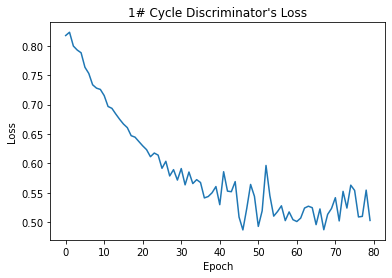

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("1# Cycle Discriminator's Loss")
plt.show() 

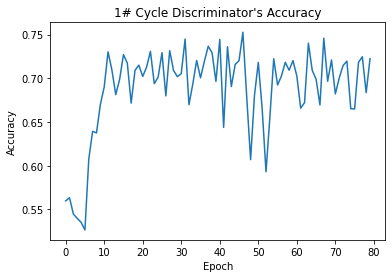

In [ ]:
plt.plot(H.history['discriminator_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("1# Cycle Discriminator's Accuracy")
plt.show() 

In [ ]:
discriminator_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(test_gen_data))

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(qdisc_model.get_weights()[0],train_gen_symbols)

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
H = train_qgen(90, 50, 1)

Epoch 1/90
2/2 [==============================] - 3s 1s/step - loss: 0.5906
Epoch 2/90
2/2 [==============================] - 4s 3s/step - loss: 0.5898
Epoch 3/90
2/2 [==============================] - 5s 3s/step - loss: 0.5891
Epoch 4/90
2/2 [==============================] - 6s 3s/step - loss: 0.5885
Epoch 5/90
2/2 [==============================] - 7s 3s/step - loss: 0.5880
Epoch 6/90
2/2 [==============================] - 6s 3s/step - loss: 0.5877
Epoch 7/90
2/2 [==============================] - 5s 3s/step - loss: 0.5874
Epoch 8/90
2/2 [==============================] - 5s 2s/step - loss: 0.5872
Epoch 9/90
2/2 [==============================] - 5s 3s/step - loss: 0.5871
Epoch 10/90
2/2 [==============================] - 5s 3s/step - loss: 0.5870
Epoch 11/90
2/2 [==============================] - 5s 2s/step - loss: 0.5870
Epoch 12/90
2/2 [==============================] - 5s 2s/step - loss: 0.5870
Epoch 13/90
2/2 [==============================] - 5s 2s/step - loss: 0.5871
Epoch 14

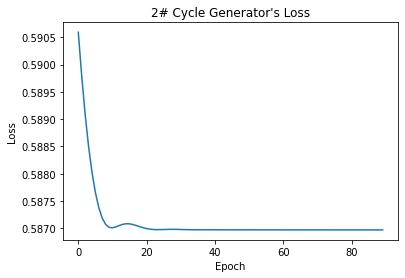

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("2# Cycle Generator's Loss")
plt.show()

In [ ]:
# Generating data for discriminator by mixing real and fake data
# Increasing value of C to make the discriminator biased towards classification part 
C = 0.7
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(qdisc_model.get_weights()[0],train_gen_symbols)

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
H = train_qdisc(70,50, 1)

Epoch 1/70
4/4 [==============================] - 4s 1s/step - loss: 0.5387 - discriminator_accuracy: 0.7131 - val_loss: 0.6562 - val_discriminator_accuracy: 0.2500
Epoch 2/70
4/4 [==============================] - 4s 1s/step - loss: 0.5411 - discriminator_accuracy: 0.6708 - val_loss: 0.6589 - val_discriminator_accuracy: 0.2500
Epoch 3/70
4/4 [==============================] - 4s 1s/step - loss: 0.5044 - discriminator_accuracy: 0.6949 - val_loss: 0.6621 - val_discriminator_accuracy: 0.2500
Epoch 4/70
4/4 [==============================] - 4s 1s/step - loss: 0.5153 - discriminator_accuracy: 0.6993 - val_loss: 0.6652 - val_discriminator_accuracy: 0.2500
Epoch 5/70
4/4 [==============================] - 4s 1s/step - loss: 0.5284 - discriminator_accuracy: 0.7366 - val_loss: 0.6678 - val_discriminator_accuracy: 0.2500
Epoch 6/70
4/4 [==============================] - 4s 1s/step - loss: 0.4710 - discriminator_accuracy: 0.7114 - val_loss: 0.6709 - val_discriminator_accuracy: 0.2500
Epoch 7/70

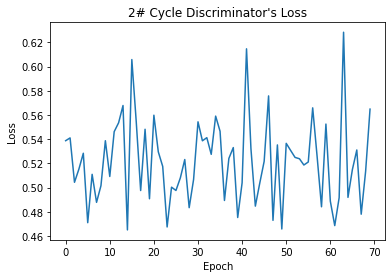

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("2# Cycle Discriminator's Loss")
plt.show() 

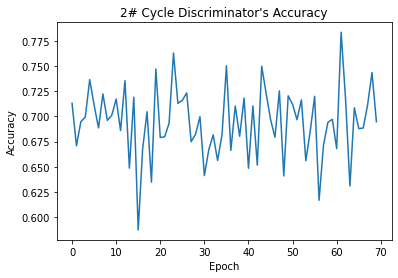

In [ ]:
plt.plot(H.history['discriminator_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("2# Cycle Discriminator's Accuracy")
plt.show() 

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(qdisc_model.get_weights()[0],train_gen_symbols)

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
H = train_qgen(80, 50, 1)

Epoch 1/80
2/2 [==============================] - 3s 1s/step - loss: 0.6401
Epoch 2/80
2/2 [==============================] - 3s 1s/step - loss: 0.6393
Epoch 3/80
2/2 [==============================] - 3s 1s/step - loss: 0.6385
Epoch 4/80
2/2 [==============================] - 3s 1s/step - loss: 0.6378
Epoch 5/80
2/2 [==============================] - 3s 1s/step - loss: 0.6371
Epoch 6/80
2/2 [==============================] - 3s 1s/step - loss: 0.6365
Epoch 7/80
2/2 [==============================] - 3s 1s/step - loss: 0.6360
Epoch 8/80
2/2 [==============================] - 3s 1s/step - loss: 0.6355
Epoch 9/80
2/2 [==============================] - 3s 1s/step - loss: 0.6350
Epoch 10/80
2/2 [==============================] - 3s 1s/step - loss: 0.6346
Epoch 11/80
2/2 [==============================] - 3s 1s/step - loss: 0.6343
Epoch 12/80
2/2 [==============================] - 3s 1s/step - loss: 0.6340
Epoch 13/80
2/2 [==============================] - 4s 2s/step - loss: 0.6337
Epoch 14

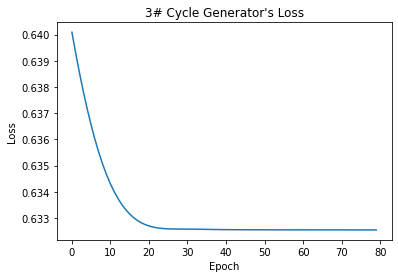

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("3# Cycle Generator's Loss")
plt.show()

In [ ]:
C = 0.85
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(qdisc_model.get_weights()[0],train_gen_symbols)

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
H = train_qdisc(100, 50, 1)

Epoch 1/100
4/4 [==============================] - 5s 1s/step - loss: 0.5095 - discriminator_accuracy: 0.7308 - val_loss: 0.7376 - val_discriminator_accuracy: 0.2500
Epoch 2/100
4/4 [==============================] - 4s 1s/step - loss: 0.4583 - discriminator_accuracy: 0.7399 - val_loss: 0.7381 - val_discriminator_accuracy: 0.2500
Epoch 3/100
4/4 [==============================] - 4s 1s/step - loss: 0.4186 - discriminator_accuracy: 0.7424 - val_loss: 0.7393 - val_discriminator_accuracy: 0.2500
Epoch 4/100
4/4 [==============================] - 4s 1s/step - loss: 0.5246 - discriminator_accuracy: 0.6561 - val_loss: 0.7394 - val_discriminator_accuracy: 0.2500
Epoch 5/100
4/4 [==============================] - 5s 1s/step - loss: 0.5109 - discriminator_accuracy: 0.7125 - val_loss: 0.7400 - val_discriminator_accuracy: 0.2500
Epoch 6/100
4/4 [==============================] - 4s 1s/step - loss: 0.6073 - discriminator_accuracy: 0.6884 - val_loss: 0.7387 - val_discriminator_accuracy: 0.2500
Epoc

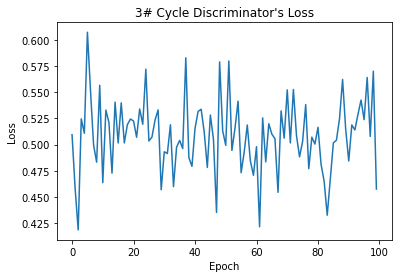

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("3# Cycle Discriminator's Loss")
plt.show()

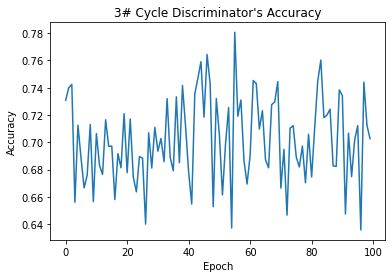

In [ ]:
plt.plot(H.history['discriminator_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("3# Cycle Discriminator's Accuracy")
plt.show() 

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(qdisc_model.get_weights()[0],train_gen_symbols)

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
H = train_qgen(70, 50, 1)

Epoch 1/70
2/2 [==============================] - 5s 2s/step - loss: 0.6265
Epoch 2/70
2/2 [==============================] - 5s 2s/step - loss: 0.6256
Epoch 3/70
2/2 [==============================] - 5s 2s/step - loss: 0.6249
Epoch 4/70
2/2 [==============================] - 5s 2s/step - loss: 0.6243
Epoch 5/70
2/2 [==============================] - 5s 2s/step - loss: 0.6240
Epoch 6/70
2/2 [==============================] - 5s 2s/step - loss: 0.6237
Epoch 7/70
2/2 [==============================] - 5s 2s/step - loss: 0.6235
Epoch 8/70
2/2 [==============================] - 5s 2s/step - loss: 0.6234
Epoch 9/70
2/2 [==============================] - 5s 2s/step - loss: 0.6233
Epoch 10/70
2/2 [==============================] - 5s 2s/step - loss: 0.6233
Epoch 11/70
2/2 [==============================] - 5s 2s/step - loss: 0.6233
Epoch 12/70
2/2 [==============================] - 6s 3s/step - loss: 0.6233
Epoch 13/70
2/2 [==============================] - 5s 2s/step - loss: 0.6233
Epoch 14

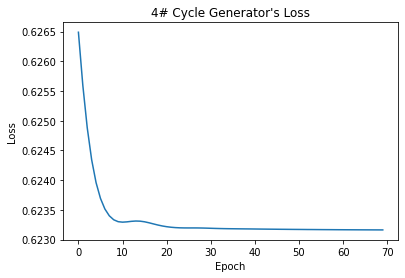

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("4# Cycle Generator's Loss")
plt.show()

In [ ]:
C = 1
# Generating data for discriminator by mixing real and fake data
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(qdisc_model.get_weights()[0],train_gen_symbols)

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
H = train_qdisc(110, 50, 1)

Epoch 1/110
4/4 [==============================] - 8s 2s/step - loss: 0.5435 - discriminator_accuracy: 0.7181 - val_loss: 0.7177 - val_discriminator_accuracy: 0.2650
Epoch 2/110
4/4 [==============================] - 7s 2s/step - loss: 0.5091 - discriminator_accuracy: 0.6807 - val_loss: 0.7175 - val_discriminator_accuracy: 0.2650
Epoch 3/110
4/4 [==============================] - 9s 2s/step - loss: 0.4536 - discriminator_accuracy: 0.7069 - val_loss: 0.7191 - val_discriminator_accuracy: 0.2550
Epoch 4/110
4/4 [==============================] - 7s 2s/step - loss: 0.4975 - discriminator_accuracy: 0.7000 - val_loss: 0.7207 - val_discriminator_accuracy: 0.2550
Epoch 5/110
4/4 [==============================] - 7s 2s/step - loss: 0.5332 - discriminator_accuracy: 0.7272 - val_loss: 0.7195 - val_discriminator_accuracy: 0.2500
Epoch 6/110
4/4 [==============================] - 7s 2s/step - loss: 0.5655 - discriminator_accuracy: 0.6730 - val_loss: 0.7173 - val_discriminator_accuracy: 0.2500
Epoc

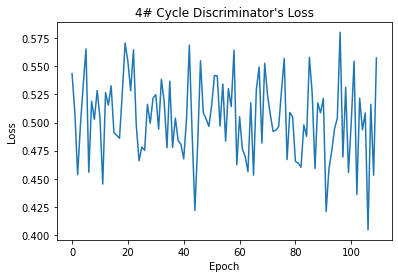

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("4# Cycle Discriminator's Loss")
plt.show()

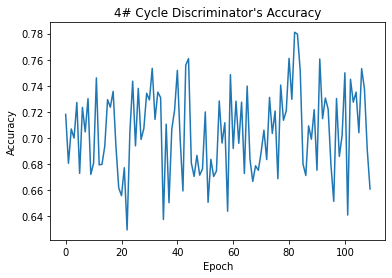

In [ ]:
plt.plot(H.history['discriminator_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("4# Cycle Discriminator's Accuracy")
plt.show() 

# **Checking on training data**

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(qdisc_model.get_weights()[0],train_gen_symbols)

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
history = qdisc_model.fit(x=train_quantum_data,
                            y=y_train,
                            batch_size=30,
                            epochs=250,
                            verbose=1,
                            validation_data=(test_quantum_data, y_test)
                            )

Epoch 1/250
4/4 [==============================] - 4s 822ms/step - loss: 0.6931 - discriminator_accuracy: 0.5000 - val_loss: 0.6948 - val_discriminator_accuracy: 0.4167
Epoch 2/250
4/4 [==============================] - 3s 851ms/step - loss: 0.6925 - discriminator_accuracy: 0.5000 - val_loss: 0.6941 - val_discriminator_accuracy: 0.4083
Epoch 3/250
4/4 [==============================] - 3s 813ms/step - loss: 0.6915 - discriminator_accuracy: 0.4833 - val_loss: 0.6933 - val_discriminator_accuracy: 0.4083
Epoch 4/250
4/4 [==============================] - 3s 803ms/step - loss: 0.6908 - discriminator_accuracy: 0.4917 - val_loss: 0.6923 - val_discriminator_accuracy: 0.4417
Epoch 5/250
4/4 [==============================] - 3s 772ms/step - loss: 0.6910 - discriminator_accuracy: 0.5333 - val_loss: 0.6917 - val_discriminator_accuracy: 0.4583
Epoch 6/250
4/4 [==============================] - 3s 707ms/step - loss: 0.6896 - discriminator_accuracy: 0.5333 - val_loss: 0.6915 - val_discriminator_acc

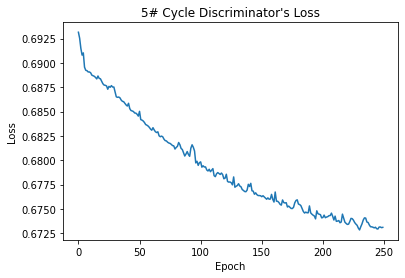

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("5# Cycle Discriminator's Loss")
plt.show()

# **Evaluation**

In [ ]:
from sklearn.metrics import roc_auc_score

print("Training Accuracy:", discriminator_accuracy(np.array(y_train, dtype=np.float32), qdisc_model.predict(train_quantum_data)).numpy())
print("Testing Accuracy", discriminator_accuracy(np.array(y_test, dtype=np.float32), qdisc_model.predict(test_quantum_data)).numpy())

print("Training AUC:", roc_auc_score(np.argmax(((y_train+1)/2)[:, :2], axis=1), (((qdisc_model.predict(train_quantum_data)+1)/2)[:, :2])[:, 1]))
print("Testing AUC:", roc_auc_score(np.argmax(((y_test+1)/2)[:, :2], axis=1), (((qdisc_model.predict(test_quantum_data)+1)/2)[:, :2])[:, 1]))

Training Accuracy: 0.66
Testing Accuracy 0.54
Training AUC: 0.5012
Testing AUC: 0.5024
